# RTM IEX Price Forecasting using Boosting & Ensembles

In [51]:
# importing required python modules
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import GridSearchCV
import xgboost
import datetime

In [54]:
# importing required datasets
price_df = pd.read_csv('dataset2.csv')

In [55]:
# inspecting price dataframe
price_df.head()

,Date,Timeblock,DAM_Price,RTM_Price,RTM_Purchase_Bid,RTM_Selling_Bid,DAM_Purchase_Bid,DAM_Selling_Bid,Demand
0,01-08-2020,1,2350.94,2900.83,1516.4,2431.6,8401.3,9522.2,160750
1,01-08-2020,2,2500.38,2900.22,1509.4,2558,8357.9,9583.2,160525
2,01-08-2020,3,2589.31,2599.48,1233.7,2698.3,8237.7,9579.2,156044
3,01-08-2020,4,2500.59,2589.91,1191.7,2770.8,7995.7,9747.2,155191
4,01-08-2020,5,2450.51,2599.61,1312.5,2725.9,7723.2,9924.2,153877


In [56]:
# checking shapes of both dataframes
price_df.shape

(16512, 9)

In [57]:
# user inputs
n_train_days = 92 # int(input("No. of Training Days: "))
n_pred_block = 96 # int(input("No. of Time Blocks to Predict: "))

In [58]:
# checking price data column types
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              16512 non-null  object 
 1   Timeblock         16512 non-null  int64  
 2   DAM_Price         16512 non-null  float64
 3   RTM_Price         16512 non-null  object 
 4   RTM_Purchase_Bid  16512 non-null  object 
 5   RTM_Selling_Bid   16512 non-null  object 
 6   DAM_Purchase_Bid  16512 non-null  float64
 7   DAM_Selling_Bid   16512 non-null  float64
 8   Demand            16512 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 1.1+ MB


In [59]:
# converting object dtypes to numeric dtype
price_df['RTM_Price'] = pd.to_numeric(price_df['RTM_Price'], errors='coerce')
price_df['DAM_Price'] = pd.to_numeric(price_df['DAM_Price'], errors='coerce')
price_df['RTM_Purchase_Bid'] = pd.to_numeric(price_df['RTM_Purchase_Bid'], errors='coerce')
price_df['RTM_Selling_Bid'] = pd.to_numeric(price_df['RTM_Selling_Bid'], errors='coerce')
price_df['DAM_Purchase_Bid'] = pd.to_numeric(price_df['DAM_Purchase_Bid'], errors='coerce')
price_df['DAM_Selling_Bid'] = pd.to_numeric(price_df['DAM_Selling_Bid'], errors='coerce')
price_df['Demand'] = pd.to_numeric(price_df['Demand'], errors='coerce')

In [60]:
# creating a column to track day of week and holidays
price_df['Date'] = pd.to_datetime(price_df.Date)
price_df['Day_of_week'] = price_df['Date'].dt.dayofweek

# create a function to check if the day of week is a weekend
def is_weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

price_df['Holiday'] = price_df['Day_of_week'].apply(is_weekend)
price_df = price_df.drop(columns=['Day_of_week'])
price_df.head()

,Date,Timeblock,DAM_Price,RTM_Price,RTM_Purchase_Bid,RTM_Selling_Bid,DAM_Purchase_Bid,DAM_Selling_Bid,Demand,Holiday
0,2020-01-08,1,2350.94,2900.83,1516.4,2431.6,8401.3,9522.2,160750,0
1,2020-01-08,2,2500.38,2900.22,1509.4,2558.0,8357.9,9583.2,160525,0
2,2020-01-08,3,2589.31,2599.48,1233.7,2698.3,8237.7,9579.2,156044,0
3,2020-01-08,4,2500.59,2589.91,1191.7,2770.8,7995.7,9747.2,155191,0
4,2020-01-08,5,2450.51,2599.61,1312.5,2725.9,7723.2,9924.2,153877,0


In [10]:
price_df.Holiday.value_counts()

0    15648
1     6528
Name: Holiday, dtype: int64

In [11]:
# check for missing values in price dataset
price_df.isna().sum()

Date                  0
Timeblock             0
DAM_Price             0
RTM_Price           103
RTM_Purchase_Bid     88
RTM_Selling_Bid      88
DAM_Purchase_Bid      0
DAM_Selling_Bid       0
Demand                0
Holiday               0
dtype: int64

In [12]:
# Assign special days as a value of 2
price_df.loc[price_df.Date == datetime.datetime(2020,8,15,0,0,0), 'Holiday'] = 2 #Independence Day
price_df.loc[price_df.Date == datetime.datetime(2020,8,1,0,0,0), 'Holiday'] = 2 #Eid
price_df.loc[price_df.Date == datetime.datetime(2020,8,3,0,0,0), 'Holiday'] = 2 #RakshaBandhan
price_df.loc[price_df.Date == datetime.datetime(2020,8,12,0,0,0), 'Holiday'] = 2 #Janmashtami
price_df.loc[price_df.Date == datetime.datetime(2020,8,22,0,0,0), 'Holiday'] = 2 #Ganesh Puja
price_df.loc[price_df.Date == datetime.datetime(2020,8,31,0,0,0), 'Holiday'] = 2 #Onam
price_df.loc[price_df.Date == datetime.datetime(2020,10,2,0,0,0), 'Holiday'] = 2 #Gandhi Jayanti
price_df.loc[price_df.Date == datetime.datetime(2020,10,25,0,0,0), 'Holiday'] = 2 #Dusshera
price_df.loc[price_df.Date == datetime.datetime(2020,10,30,0,0,0), 'Holiday'] = 2 #Good Friday
price_df.loc[price_df.Date == datetime.datetime(2020,11,14,0,0,0), 'Holiday'] = 2 #Diwali
price_df.loc[price_df.Date == datetime.datetime(2020,12,25,0,0,0), 'Holiday'] = 2 #Christmas
price_df.loc[price_df.Date == datetime.datetime(2020,12,31,0,0,0), 'Holiday'] = 2 #New Year

In [13]:
price_df.Holiday.value_counts()

0    15264
1     6240
2      672
Name: Holiday, dtype: int64

In [14]:
# create two dataframe to hold values
df1 = pd.DataFrame()
df2 = pd.DataFrame()

In [15]:
price_df[672:].head()

,Date,Timeblock,DAM_Price,RTM_Price,RTM_Purchase_Bid,RTM_Selling_Bid,DAM_Purchase_Bid,DAM_Selling_Bid,Demand,Holiday
672,2020-06-10,1,2700.90,4001.37,2691.2,1075.8,8516.6,9224.9,150689,0
673,2020-06-10,2,2699.22,4000.57,2640.2,1242.5,8285.1,9287.6,150607,0
674,2020-06-10,3,2599.16,3989.51,2372.2,1467.5,8060.1,9487.9,149732,0
675,2020-06-10,4,2600.64,3989.39,2340.2,1456.0,8118.1,9581.9,149150,0
676,2020-06-10,5,2639.71,3500.21,1624.3,1222.2,8202.6,9687.9,147983,0


In [16]:
# starting from 10th of June
june10_index = 672
df1['Timeblock'] = price_df['Timeblock'][june10_index:]
df1['Holiday'] = price_df['Holiday'][june10_index:]
df1['DAM_Price'] = price_df['DAM_Price'][june10_index:]
df1['DAM_Purchase_Bid'] = price_df['DAM_Purchase_Bid'][june10_index:]
df1['DAM_Selling_Bid'] = price_df['DAM_Selling_Bid'][june10_index:]
df1['RTM_Price_SD'] = price_df['RTM_Price'][june10_index:]

In [17]:
price_df[:-672].tail()

,Date,Timeblock,DAM_Price,RTM_Price,RTM_Purchase_Bid,RTM_Selling_Bid,DAM_Purchase_Bid,DAM_Selling_Bid,Demand,Holiday
21499,2021-01-12,92,2349.18,2619.10,1448.4,5003.3,5907.7,13820.2,134938,0
21500,2021-01-12,93,2399.68,2400.38,1218.1,5380.0,6132.7,13900.3,133046,0
21501,2021-01-12,94,2411.29,2499.21,1213.1,5357.0,6420.1,13457.3,131531,0
21502,2021-01-12,95,2324.79,1799.96,1158.7,5702.5,6463.6,13903.9,130332,0
21503,2021-01-12,96,2249.00,1799.43,1039.0,5786.5,6642.5,13667.9,128852,0


In [18]:
df1.reset_index(inplace = True)
df1 = df1.drop(['index'], axis = 1)

last_wkday_index = -672
#Taking stats from same day last week(Same day is 10th June so starting same day last week is 3rd June)
df1['RTM_Price_SDLW'] = price_df['RTM_Price'][:last_wkday_index]
df1['RTM_Purchase_Bid_SDLW'] = price_df['RTM_Purchase_Bid'][:last_wkday_index]
df1['RTM_Selling_Bid_SDLW'] = price_df['RTM_Selling_Bid'][:last_wkday_index]
df1.head()

,Timeblock,Holiday,DAM_Price,DAM_Purchase_Bid,DAM_Selling_Bid,RTM_Price_SD,RTM_Price_SDLW,RTM_Purchase_Bid_SDLW,RTM_Selling_Bid_SDLW
0,1,0,2700.90,8516.6,9224.9,4001.37,1700.86,519.6,2400.0
1,2,0,2699.22,8285.1,9287.6,4000.57,1876.17,533.1,2252.4
2,3,0,2599.16,8060.1,9487.9,3989.51,1749.68,433.1,2331.1
3,4,0,2600.64,8118.1,9581.9,3989.39,1749.44,419.6,2296.3
4,5,0,2639.71,8202.6,9687.9,3500.21,1930.72,700.5,2247.5


In [19]:
#Taking stats from previous day(Same day is 10th June so previous day starts from 9th June)
june9_index = 576
df2['RTM_Price_PD'] = price_df['RTM_Price'][june9_index:-96]
df2['RTM_Purchase_Bid_PD'] = price_df['RTM_Purchase_Bid'][june9_index:-96]
df2['RTM_Selling_Bid_PD'] = price_df['RTM_Selling_Bid'][june9_index:-96]
df2.reset_index(inplace = True)
df2.drop('index', axis=1, inplace=True)
df2.head()

,RTM_Price_PD,RTM_Purchase_Bid_PD,RTM_Selling_Bid_PD
0,3895.58,2917.2,1150.1
1,3586.93,2865.2,1230.1
2,3000.80,2120.5,1575.8
3,3000.76,2080.5,1572.8
4,2760.75,1444.5,1498.2


In [20]:
# check shapes of both dataframes
df1.shape, df2.shape

((21504, 9), (21504, 3))

In [21]:
df1['RTM_Price_PD'] = df2['RTM_Price_PD']
df1['RTM_Purchase_Bid_PD'] = df2['RTM_Purchase_Bid_PD']
df1['RTM_Selling_Bid_PD'] = df2['RTM_Selling_Bid_PD']

df1 = df1[['Timeblock','Holiday','DAM_Price','DAM_Purchase_Bid','DAM_Selling_Bid','RTM_Price_PD',
           'RTM_Purchase_Bid_PD','RTM_Selling_Bid_PD','RTM_Price_SDLW','RTM_Purchase_Bid_SDLW', \
           'RTM_Selling_Bid_SDLW', 'RTM_Price_SD']]

df1.head()

,Timeblock,Holiday,DAM_Price,DAM_Purchase_Bid,DAM_Selling_Bid,RTM_Price_PD,RTM_Purchase_Bid_PD,RTM_Selling_Bid_PD,RTM_Price_SDLW,RTM_Purchase_Bid_SDLW,RTM_Selling_Bid_SDLW,RTM_Price_SD
0,1,0,2700.90,8516.6,9224.9,3895.58,2917.2,1150.1,1700.86,519.6,2400.0,4001.37
1,2,0,2699.22,8285.1,9287.6,3586.93,2865.2,1230.1,1876.17,533.1,2252.4,4000.57
2,3,0,2599.16,8060.1,9487.9,3000.80,2120.5,1575.8,1749.68,433.1,2331.1,3989.51
3,4,0,2600.64,8118.1,9581.9,3000.76,2080.5,1572.8,1749.44,419.6,2296.3,3989.39
4,5,0,2639.71,8202.6,9687.9,2760.75,1444.5,1498.2,1930.72,700.5,2247.5,3500.21


In [22]:
"""
demand_df['StateLoad'] = pd.to_numeric(demand_df['StateLoad'], errors='coerce')
demand_df['StateLoad'].isna().sum()

date_df = demand_df[['DataDate']]
date_df = date_df.drop_duplicates()
date_df.reset_index(inplace = True)
date_df = date_df.drop(['index'], axis = 1)

block_df = demand_df[['Block']]
block_df = block_df.drop_duplicates()
block_df = block_df.sort_values(by=['Block'])
block_df.reset_index(inplace = True)
block_df = block_df.drop(['index'], axis = 1)


demand = []
for i in date_df['DataDate']:
    for j in block_df['Block']:
        demand_sum = demand_df.loc[(demand_df['DataDate']==i) & (demand_df['Block']==j),'StateLoad'].sum()
        demand.append(demand_sum)

for i in range(len(demand)):
    if demand[i] == 0:
        demand[i] = demand[i-1]

dm_df= pd.DataFrame({'Demand':demand})
"""
#Taking demand of previous day(Same day is 10th June so previous day starts from 9th June)

df2= pd.DataFrame()
df2['Demand PD'] = price_df['Demand'][768:-96]

df2.reset_index(inplace = True)
df2 = df2.drop(['index'], axis = 1)

df1['Demand PD'] = df2['Demand PD']

#Taking stats from same day last week(Same day is 10th June so starting same day last week is 3rd June)
df2= pd.DataFrame()
df2['Demand SDLW'] = price_df['Demand'][192:-672]

df2.reset_index(inplace = True)
df2 = df2.drop(['index'], axis = 1)

df1['Demand SDLW'] = df2['Demand SDLW']

        

In [23]:
df1.head()

,Timeblock,Holiday,DAM_Price,DAM_Purchase_Bid,DAM_Selling_Bid,RTM_Price_PD,RTM_Purchase_Bid_PD,RTM_Selling_Bid_PD,RTM_Price_SDLW,RTM_Purchase_Bid_SDLW,RTM_Selling_Bid_SDLW,RTM_Price_SD,Demand PD,Demand SDLW
0,1,0,2700.90,8516.6,9224.9,3895.58,2917.2,1150.1,1700.86,519.6,2400.0,4001.37,147656.0,126810.0
1,2,0,2699.22,8285.1,9287.6,3586.93,2865.2,1230.1,1876.17,533.1,2252.4,4000.57,146825.0,126379.0
2,3,0,2599.16,8060.1,9487.9,3000.80,2120.5,1575.8,1749.68,433.1,2331.1,3989.51,145790.0,125192.0
3,4,0,2600.64,8118.1,9581.9,3000.76,2080.5,1572.8,1749.44,419.6,2296.3,3989.39,145339.0,124323.0
4,5,0,2639.71,8202.6,9687.9,2760.75,1444.5,1498.2,1930.72,700.5,2247.5,3500.21,144461.0,111357.0


In [24]:
df1 = df1.rename({'Demand PD': 'Demand_PD', 'Demand SDLW': 'Demand_SDLW'}, axis=1)
df1.head()

,Timeblock,Holiday,DAM_Price,DAM_Purchase_Bid,DAM_Selling_Bid,RTM_Price_PD,RTM_Purchase_Bid_PD,RTM_Selling_Bid_PD,RTM_Price_SDLW,RTM_Purchase_Bid_SDLW,RTM_Selling_Bid_SDLW,RTM_Price_SD,Demand_PD,Demand_SDLW
0,1,0,2700.90,8516.6,9224.9,3895.58,2917.2,1150.1,1700.86,519.6,2400.0,4001.37,147656.0,126810.0
1,2,0,2699.22,8285.1,9287.6,3586.93,2865.2,1230.1,1876.17,533.1,2252.4,4000.57,146825.0,126379.0
2,3,0,2599.16,8060.1,9487.9,3000.80,2120.5,1575.8,1749.68,433.1,2331.1,3989.51,145790.0,125192.0
3,4,0,2600.64,8118.1,9581.9,3000.76,2080.5,1572.8,1749.44,419.6,2296.3,3989.39,145339.0,124323.0
4,5,0,2639.71,8202.6,9687.9,2760.75,1444.5,1498.2,1930.72,700.5,2247.5,3500.21,144461.0,111357.0


In [25]:
df1.tail()

,Timeblock,Holiday,DAM_Price,DAM_Purchase_Bid,DAM_Selling_Bid,RTM_Price_PD,RTM_Purchase_Bid_PD,RTM_Selling_Bid_PD,RTM_Price_SDLW,RTM_Purchase_Bid_SDLW,RTM_Selling_Bid_SDLW,RTM_Price_SD,Demand_PD,Demand_SDLW
21499,92,0,2150.34,5543.8,13425.9,2589.38,1869.4,4375.9,2619.10,1448.4,5003.3,2669.49,NaN,NaN
21500,93,0,2099.44,5351.2,14851.1,2399.37,1905.2,5337.7,2400.38,1218.1,5380.0,2589.49,NaN,NaN
21501,94,0,2050.40,5313.1,15551.1,2249.86,1765.2,5438.7,2499.21,1213.1,5357.0,2579.87,NaN,NaN
21502,95,0,2118.23,5426.9,15568.7,2589.81,1785.2,4732.9,1799.96,1158.7,5702.5,2589.32,NaN,NaN
21503,96,0,2099.74,5636.2,15513.6,2579.28,1661.6,4815.7,1799.43,1039.0,5786.5,2579.70,NaN,NaN


In [26]:
# check the no of missing values in each column
df1.isna().sum()

Timeblock                  0
Holiday                    0
DAM_Price                  0
DAM_Purchase_Bid           0
DAM_Selling_Bid            0
RTM_Price_PD              79
RTM_Purchase_Bid_PD       64
RTM_Selling_Bid_PD        64
RTM_Price_SDLW           101
RTM_Purchase_Bid_SDLW     86
RTM_Selling_Bid_SDLW      86
RTM_Price_SD              79
Demand_PD                192
Demand_SDLW              192
dtype: int64

In [27]:
# filling the value from previous timeblock for all NaN or NA
df1 = df1.ffill(axis = 0)
df1.isna().sum()

Timeblock                0
Holiday                  0
DAM_Price                0
DAM_Purchase_Bid         0
DAM_Selling_Bid          0
RTM_Price_PD             0
RTM_Purchase_Bid_PD      0
RTM_Selling_Bid_PD       0
RTM_Price_SDLW           0
RTM_Purchase_Bid_SDLW    0
RTM_Selling_Bid_SDLW     0
RTM_Price_SD             0
Demand_PD                0
Demand_SDLW              0
dtype: int64

<AxesSubplot:>

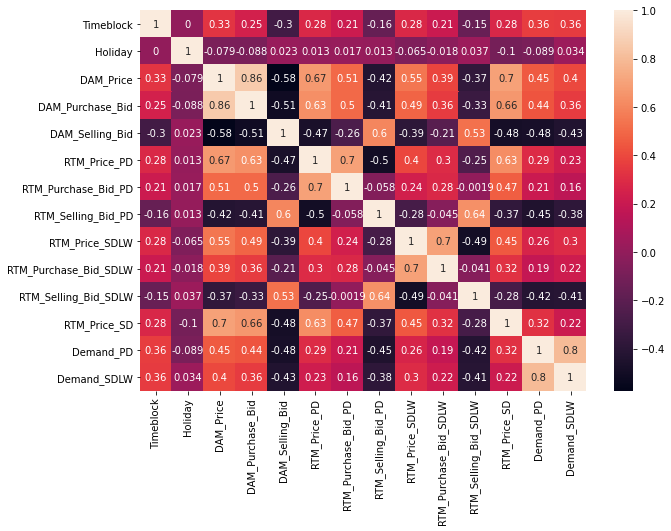

In [28]:
plt.figure(figsize=(10,7))
sns.heatmap(df1.corr(), annot=True)

In [29]:
# create dummy variables for Holidays and Time Blocks
df1 = pd.get_dummies(df1, columns = ['Holiday'] )
df1 = pd.get_dummies(df1, columns = ['Timeblock'] )
df1 = df1[['Timeblock_1','Timeblock_2','Timeblock_3','Timeblock_4','Timeblock_5','Timeblock_6','Timeblock_7',
           'Timeblock_8','Timeblock_9','Timeblock_10','Timeblock_11','Timeblock_12','Timeblock_13','Timeblock_14',
           'Timeblock_15','Timeblock_16','Timeblock_17','Timeblock_18','Timeblock_19','Timeblock_20','Timeblock_21',
           'Timeblock_22','Timeblock_23','Timeblock_24','Timeblock_25','Timeblock_26','Timeblock_27','Timeblock_28',
           'Timeblock_29','Timeblock_30','Timeblock_31','Timeblock_32','Timeblock_33','Timeblock_34','Timeblock_35',
           'Timeblock_36','Timeblock_37','Timeblock_38','Timeblock_39','Timeblock_40','Timeblock_41','Timeblock_42',
           'Timeblock_43','Timeblock_44','Timeblock_45','Timeblock_46','Timeblock_47','Timeblock_48','Timeblock_49',
           'Timeblock_50','Timeblock_51','Timeblock_52','Timeblock_53','Timeblock_54','Timeblock_55','Timeblock_56',
           'Timeblock_57','Timeblock_58','Timeblock_59','Timeblock_60','Timeblock_61','Timeblock_62','Timeblock_63',
           'Timeblock_64','Timeblock_65','Timeblock_66','Timeblock_67','Timeblock_68','Timeblock_69','Timeblock_70',
           'Timeblock_71','Timeblock_72','Timeblock_73','Timeblock_74','Timeblock_75','Timeblock_76','Timeblock_77',
           'Timeblock_78','Timeblock_79','Timeblock_80','Timeblock_81','Timeblock_82','Timeblock_83','Timeblock_84',
           'Timeblock_85','Timeblock_86','Timeblock_87','Timeblock_88','Timeblock_89','Timeblock_90','Timeblock_91',
           'Timeblock_92','Timeblock_93','Timeblock_94','Timeblock_95','Timeblock_96','Holiday_0','Holiday_1',
           'Holiday_2','DAM_Price', 'DAM_Purchase_Bid', 'DAM_Selling_Bid', 'RTM_Price_PD', 'RTM_Purchase_Bid_PD', 
           'RTM_Selling_Bid_PD', 'RTM_Price_SDLW', 'RTM_Purchase_Bid_SDLW', 'RTM_Selling_Bid_SDLW', 
           'Demand_PD', 'RTM_Price_SD']]
df1.head()

,Timeblock_1,Timeblock_2,Timeblock_3,Timeblock_4,Timeblock_5,Timeblock_6,Timeblock_7,Timeblock_8,Timeblock_9,Timeblock_10,...,DAM_Purchase_Bid,DAM_Selling_Bid,RTM_Price_PD,RTM_Purchase_Bid_PD,RTM_Selling_Bid_PD,RTM_Price_SDLW,RTM_Purchase_Bid_SDLW,RTM_Selling_Bid_SDLW,Demand_PD,RTM_Price_SD
0,1,0,0,0,0,0,0,0,0,0,...,8516.6,9224.9,3895.58,2917.2,1150.1,1700.86,519.6,2400.0,147656.0,4001.37
1,0,1,0,0,0,0,0,0,0,0,...,8285.1,9287.6,3586.93,2865.2,1230.1,1876.17,533.1,2252.4,146825.0,4000.57
2,0,0,1,0,0,0,0,0,0,0,...,8060.1,9487.9,3000.80,2120.5,1575.8,1749.68,433.1,2331.1,145790.0,3989.51
3,0,0,0,1,0,0,0,0,0,0,...,8118.1,9581.9,3000.76,2080.5,1572.8,1749.44,419.6,2296.3,145339.0,3989.39
4,0,0,0,0,1,0,0,0,0,0,...,8202.6,9687.9,2760.75,1444.5,1498.2,1930.72,700.5,2247.5,144461.0,3500.21


In [30]:
# creating dependent and independent variable
X = df1.iloc[:,:-1].values
y = df1.iloc[:,-1].values

In [31]:
# checking shape of both data
X.shape, y.shape

((21504, 109), (21504,))

In [32]:
# creating train test split
# predicting the RTM Price 
# 1 signifies finding value of latest day and as n value increases we move backward from current day
n = 1
X_train,y_train  = X[-(n_train_days + n)*96:-96*n,:] , y[-(n_train_days + n)*96:-96*n]
if n > 1:
    if n_pred_block == 96:
        X_test , y_test = X[-96*n:-96*(n-1),:] , y[-96*n:-96*(n-1)] #Remember -96*n:-96*(n-1) for both X and y here
    else:
        X_test , y_test = X[-96*n:-96*n + n_pred_block, :] , y[-96*n:-96*n + n_pred_block]

if n==1:
    if n_pred_block == 96:
        X_test , y_test = X[-96*n:, :] , y[-96*n:] #Remember -96*n:-96*(n-1) for both X and y here
    else:
        X_test , y_test = X[-96*n:-96*n + n_pred_block, :] , y[-96*n:-96*n + n_pred_block]

In [33]:
-96*n

-96

In [34]:
n_pred_block

96

In [35]:
-96*n - n_pred_block

-192

In [36]:
 X[-96*n:-96*n - n_pred_block].shape

(0, 109)

In [37]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8832, 109), (8832,), (96, 109), (96,))

In [38]:
#Hyperparameter Tuning of Xgboost Model

parameters_for_testing = {
    'colsample_bytree':[0.8,0.9],
    'gamma':[0.05,0.1],
    'min_samples_leaf':[3,5,7],
    'learning_rate':[0.05,0.07],
    'max_depth':[5,7],
    'n_estimators':[100, 150, 200]
     }
xgb_model = xgboost.XGBRegressor()

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=-1,
                        verbose=1,scoring='neg_mean_squared_error')
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  4.3min finished


[13:10:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [39]:
#print (gsearch1.cv_results_)
print('Best Params:', gsearch1.best_params_)
print('Best Score:', gsearch1.best_score_)
print('Best Estimator:', gsearch1.best_estimator_)

Best Params: {'colsample_bytree': 0.8, 'gamma': 0.05, 'learning_rate': 0.07, 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}
Best Score: -297856.65361082973
Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=5,
             min_child_weight=1, min_samples_leaf=3, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=48,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [40]:
best_regr = gsearch1.best_estimator_
best_regr.fit(X_train,y_train)

y_predict1 = best_regr.predict(X_test)

[13:10:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [41]:
test_diff = np.abs(y_predict1 - y_test)

#MAE for test set
diff_day = []
diff_sum = 0
time = 0
for i in test_diff:
    if time != n_pred_block-1:
        diff_sum +=i
        time +=1
    else:
        diff_sum = diff_sum/n_pred_block
        diff_day.append(diff_sum)
        diff_sum = 0
        time = 0
        
#MAPE for test set
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape0 = mean_absolute_percentage_error(y_test, y_predict1)
print('MAPE =' ,mape0)

#Max error and Min Error for the test set
max_error  = max(test_diff)
min_error = min(test_diff)

print('Maximum Error of the day = ',max_error)
print('Minimum Error of the day = ',min_error)
print('MAE of the day = ',diff_day)#mae

print('Average RTM Price = ',np.mean(y_test))
print('Average DAM Price = ',X_test[:,99].mean())

mape1 = mean_absolute_percentage_error(y_test[:24],y_predict1[:24])
mape2 = mean_absolute_percentage_error(y_test[24:48],y_predict1[24:48])
mape3 = mean_absolute_percentage_error(y_test[48:72],y_predict1[48:72])
mape4 = mean_absolute_percentage_error(y_test[72:],y_predict1[72:])
#Error during different sections of day:
print('MAPE during 00:00-06:00 hrs = ',mape1)
print('MAPE during 06:00-12:00 hrs = ',mape2)
print('MAPE during 12:00-18:00 hrs = ',mape3)
print('MAPE during 18:00-24:00 hrs = ',mape4)
print('MAPE Full day 00:00-24:00 hrs = ', ((mape1+mape2+mape3+mape4)/4))

MAPE = 10.762444145555788
Maximum Error of the day =  2138.7783203125
Minimum Error of the day =  20.49326171875009
MAE of the day =  [440.60946268717436]
Average RTM Price =  3989.9464583333333
Average DAM Price =  3617.9903125
MAPE during 00:00-06:00 hrs =  11.773262544339982
MAPE during 06:00-12:00 hrs =  9.523836297457978
MAPE during 12:00-18:00 hrs =  12.005127398652327
MAPE during 18:00-24:00 hrs =  9.747550341772866
MAPE Full day 00:00-24:00 hrs =  10.762444145555788


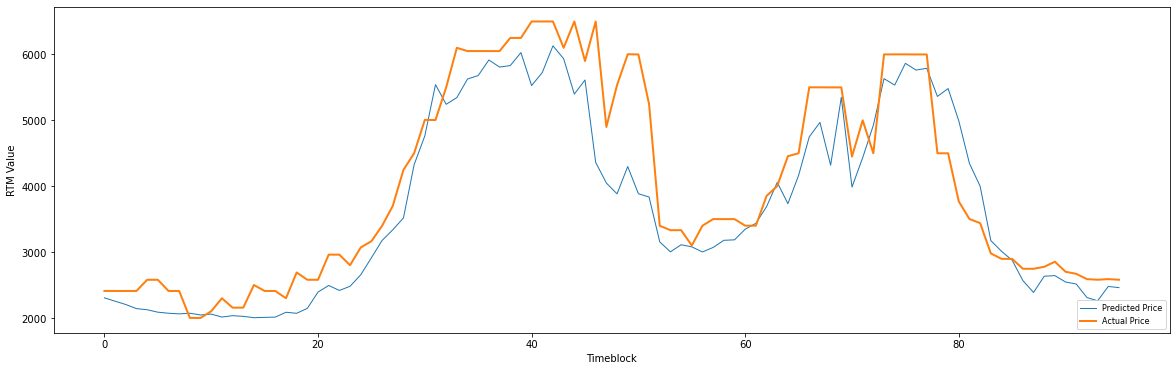

In [42]:
#Plotting for the test day
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.xlabel('Timeblock', fontsize = 10)
plt.ylabel('RTM Value', fontsize = 10)
plt.plot(y_predict1, label = 'Predicted Price', linewidth=1)
plt.plot(y_test, label = 'Actual Price',  linewidth=2)
plt.legend(loc = 'lower right',frameon=True,  prop={"size":8});
plt.show()

In [43]:
    
    
#Saving the predicted and actual value to csv file
save_df = pd.DataFrame({"Actual RTM Price" : y_test, "Predicted RTM Price" : y_predict1,"Difference": test_diff})
save_df.to_csv("Forecast.csv", index=False)

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [5,7,10],
    'max_features': [3,4,5],
    'min_samples_leaf': [5,7],
    'min_samples_split': [6, 8, 10],
    'n_estimators': [100,150,200]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train,y_train)
print('best params')
print (grid_search.best_params_)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:   28.5s finished


best params
{'bootstrap': False, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 100}
Model Performance
Average Error: 812.2662 degrees.
Accuracy = 83.32%.


MAPE = 16.51350380878341
Maximum Error of the day =  2709.4512196629157
Minimum Error of the day =  1.2250189379119547
MAE of the day =  [798.6782537585992]
Average RTM Price =  3989.9464583333333
Average DAM Price =  3617.9903125
MAPE during 00:00-06:00 hrs =  8.891105822604645
MAPE during 06:00-12:00 hrs =  26.084116934654205
MAPE during 12:00-18:00 hrs =  19.368478248204905
MAPE during 18:00-24:00 hrs =  11.710314229669876


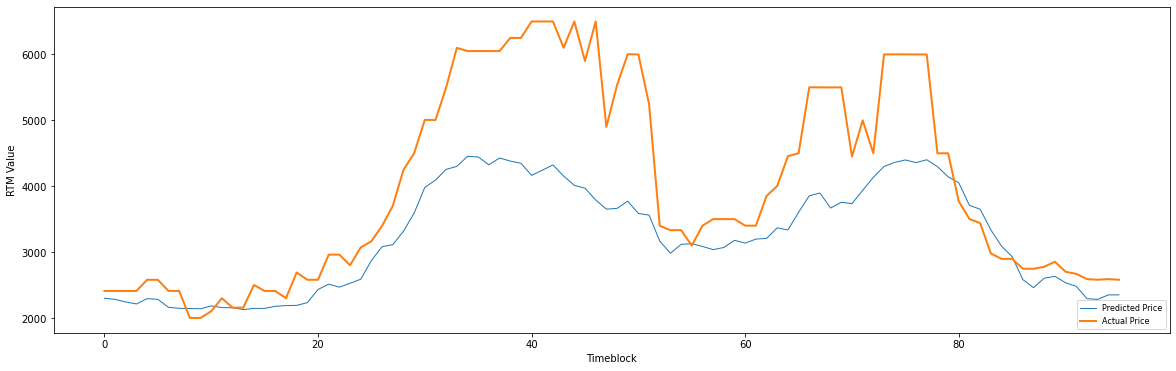

In [46]:
best_regr = best_grid
best_regr.fit(X_train,y_train)

y_predict1 = best_regr.predict(X_test)


#Difference in test and predict value per day
import numpy as np
test_diff = np.abs(y_predict1 - y_test)

#MAE for test set
diff_day = []
diff_sum = 0
time = 0
for i in test_diff:
    if time != n_pred_block-1:
        diff_sum +=i
        time +=1
    else:
        diff_sum = diff_sum/n_pred_block
        diff_day.append(diff_sum)
        diff_sum = 0
        time = 0
        
#MAPE for test set
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape0 = mean_absolute_percentage_error(y_test, y_predict1)
print('MAPE =' ,mape0)

#Max error and Min Error for the test set
max_error  = max(test_diff)
min_error = min(test_diff)

print('Maximum Error of the day = ',max_error)
print('Minimum Error of the day = ',min_error)
print('MAE of the day = ',diff_day)#mae

print('Average RTM Price = ',np.mean(y_test))
print('Average DAM Price = ',X_test[:,99].mean())

mape1 = mean_absolute_percentage_error(y_test[:24],y_predict1[:24])
mape2 = mean_absolute_percentage_error(y_test[24:48],y_predict1[24:48])
mape3 = mean_absolute_percentage_error(y_test[48:72],y_predict1[48:72])
mape4 = mean_absolute_percentage_error(y_test[72:],y_predict1[72:])
#Error during different sections of day:
print('MAPE during 00:00-06:00 hrs = ',mape1)
print('MAPE during 06:00-12:00 hrs = ',mape2)
print('MAPE during 12:00-18:00 hrs = ',mape3)
print('MAPE during 18:00-24:00 hrs = ',mape4)



#Plotting for the test day
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.xlabel('Timeblock', fontsize = 10)
plt.ylabel('RTM Value', fontsize = 10)
plt.plot(y_predict1, label = 'Predicted Price', linewidth=1)
plt.plot(y_test, label = 'Actual Price',  linewidth=2)
plt.legend(loc = 'lower right',frameon=True,  prop={"size":8});
plt.show()



#Saving the predicted and actual value to csv file
save_df = pd.DataFrame({"Actual RTM Price" : y_test, "Predicted RTM Price" : y_predict1,"Difference": test_diff})
save_df.to_csv("Forecast_RF.csv", index=False)

In [47]:
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [10,15],
    'max_features': [5,6],
    'min_samples_leaf': [4,5],
    'min_samples_split': [7,8],
    'n_estimators': [200,300,400,500]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          n_jobs = -1, verbose = 2)

grid_search.fit(X_train,y_train)
print('best params')
print (grid_search.best_params_)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.3min finished


best params
{'bootstrap': False, 'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}
Model Performance
Average Error: 722.9754 degrees.
Accuracy = 84.60%.


MAPE = 15.211095746185663
Maximum Error of the day =  2539.016375367191
Minimum Error of the day =  10.117964396869866
MAE of the day =  [709.8726493227923]
Average RTM Price =  3989.9464583333333
Average DAM Price =  3617.9903125
MAPE during 00:00-06:00 hrs =  10.659061323282744
MAPE during 06:00-12:00 hrs =  22.262536003481195
MAPE during 12:00-18:00 hrs =  17.125350639625754
MAPE during 18:00-24:00 hrs =  10.797435018352953


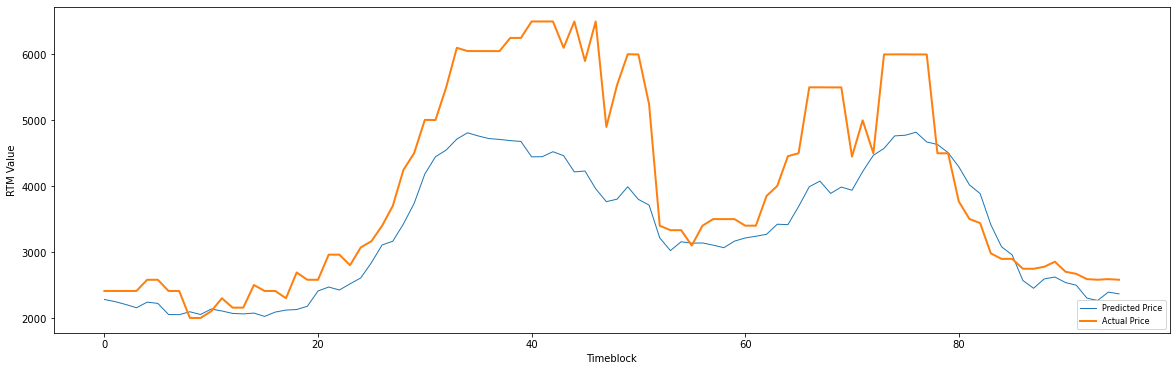

In [48]:
best_regr = best_grid
best_regr.fit(X_train,y_train)

y_predict1 = best_regr.predict(X_test)


#Difference in test and predict value per day
import numpy as np
test_diff = np.abs(y_predict1 - y_test)

#MAE for test set
diff_day = []
diff_sum = 0
time = 0
for i in test_diff:
    if time != n_pred_block-1:
        diff_sum +=i
        time +=1
    else:
        diff_sum = diff_sum/n_pred_block
        diff_day.append(diff_sum)
        diff_sum = 0
        time = 0
        
#MAPE for test set
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape0 = mean_absolute_percentage_error(y_test, y_predict1)
print('MAPE =' ,mape0)

#Max error and Min Error for the test set
max_error  = max(test_diff)
min_error = min(test_diff)

print('Maximum Error of the day = ',max_error)
print('Minimum Error of the day = ',min_error)
print('MAE of the day = ',diff_day)#mae

print('Average RTM Price = ',np.mean(y_test))
print('Average DAM Price = ',X_test[:,99].mean())

mape1 = mean_absolute_percentage_error(y_test[:24],y_predict1[:24])
mape2 = mean_absolute_percentage_error(y_test[24:48],y_predict1[24:48])
mape3 = mean_absolute_percentage_error(y_test[48:72],y_predict1[48:72])
mape4 = mean_absolute_percentage_error(y_test[72:],y_predict1[72:])
#Error during different sections of day:
print('MAPE during 00:00-06:00 hrs = ',mape1)
print('MAPE during 06:00-12:00 hrs = ',mape2)
print('MAPE during 12:00-18:00 hrs = ',mape3)
print('MAPE during 18:00-24:00 hrs = ',mape4)



#Plotting for the test day
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.xlabel('Timeblock', fontsize = 10)
plt.ylabel('RTM Value', fontsize = 10)
plt.plot(y_predict1, label = 'Predicted Price', linewidth=1)
plt.plot(y_test, label = 'Actual Price',  linewidth=2)
plt.legend(loc = 'lower right',frameon=True,  prop={"size":8});
plt.show()



#Saving the predicted and actual value to csv file
save_df = pd.DataFrame({"Actual RTM Price" : y_test, "Predicted RTM Price" : y_predict1,"Difference": test_diff})
save_df.to_csv("Forecast_RF.csv", index=False)

In [49]:
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [15,20],
    'max_features': [10, 15,20],
    'min_samples_leaf': [4,5,7],
    'min_samples_split': [18,24,36],
    'n_estimators': [500, 600, 750, 1000]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          n_jobs = -1, verbose = 2)

grid_search.fit(X_train,y_train)
print('best params')
print (grid_search.best_params_)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1889 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 17.1min finished


best params
{'bootstrap': True, 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 4, 'min_samples_split': 24, 'n_estimators': 500}
Model Performance
Average Error: 657.2192 degrees.
Accuracy = 85.61%.


MAPE = 14.350447202831237
Maximum Error of the day =  2379.7367120817344
Minimum Error of the day =  3.0378567396182916
MAE of the day =  [653.2281806908064]
Average RTM Price =  3989.9464583333333
Average DAM Price =  3617.9903125
MAPE during 00:00-06:00 hrs =  12.015874337858131
MAPE during 06:00-12:00 hrs =  19.450249422249524
MAPE during 12:00-18:00 hrs =  15.615610183448306
MAPE during 18:00-24:00 hrs =  10.320054867768992


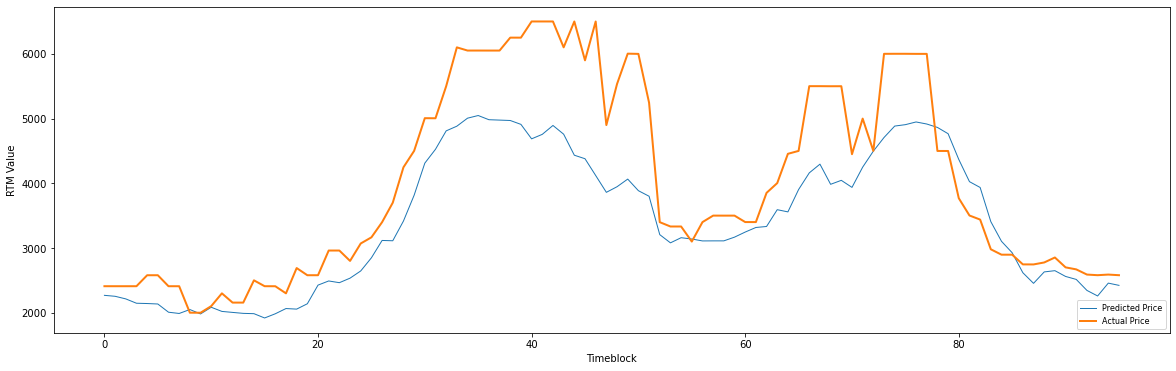

In [50]:
best_regr = best_grid
best_regr.fit(X_train,y_train)

y_predict1 = best_regr.predict(X_test)


#Difference in test and predict value per day
import numpy as np
test_diff = np.abs(y_predict1 - y_test)

#MAE for test set
diff_day = []
diff_sum = 0
time = 0
for i in test_diff:
    if time != n_pred_block-1:
        diff_sum +=i
        time +=1
    else:
        diff_sum = diff_sum/n_pred_block
        diff_day.append(diff_sum)
        diff_sum = 0
        time = 0
        
#MAPE for test set
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape0 = mean_absolute_percentage_error(y_test, y_predict1)
print('MAPE =' ,mape0)

#Max error and Min Error for the test set
max_error  = max(test_diff)
min_error = min(test_diff)

print('Maximum Error of the day = ',max_error)
print('Minimum Error of the day = ',min_error)
print('MAE of the day = ',diff_day)#mae

print('Average RTM Price = ',np.mean(y_test))
print('Average DAM Price = ',X_test[:,99].mean())

mape1 = mean_absolute_percentage_error(y_test[:24],y_predict1[:24])
mape2 = mean_absolute_percentage_error(y_test[24:48],y_predict1[24:48])
mape3 = mean_absolute_percentage_error(y_test[48:72],y_predict1[48:72])
mape4 = mean_absolute_percentage_error(y_test[72:],y_predict1[72:])
#Error during different sections of day:
print('MAPE during 00:00-06:00 hrs = ',mape1)
print('MAPE during 06:00-12:00 hrs = ',mape2)
print('MAPE during 12:00-18:00 hrs = ',mape3)
print('MAPE during 18:00-24:00 hrs = ',mape4)



#Plotting for the test day
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.xlabel('Timeblock', fontsize = 10)
plt.ylabel('RTM Value', fontsize = 10)
plt.plot(y_predict1, label = 'Predicted Price', linewidth=1)
plt.plot(y_test, label = 'Actual Price',  linewidth=2)
plt.legend(loc = 'lower right',frameon=True,  prop={"size":8});
plt.show()



#Saving the predicted and actual value to csv file
save_df = pd.DataFrame({"Actual RTM Price" : y_test, "Predicted RTM Price" : y_predict1,"Difference": test_diff})
save_df.to_csv("Forecast_RF_1.csv", index=False)